In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter

In [2]:
def get_profiler_metrics_data(file):
    calls_metrics = {'Method': [], 'Calls': []}
    root = ElementTree.parse(file).getroot()
    for type_tag in root.findall('Function'):
        method = type_tag.get('FQN')
        calls = type_tag.get('Calls')
        method = method.replace(' ', '')

        calls_metrics['Method'].append(method)
        calls_metrics['Calls'].append(int(calls))

    return pd.DataFrame(data=calls_metrics)


def get_all_profiler_metrics_data():
    calls_dfs = []
    folder = "C:/Users/aprodea/work/metrics-tax-compare/profiler/usage"
    with os.scandir(folder) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith('.xml'):
                full_path = os.path.join(folder, entry.name)
                calls_dfs.append(get_profiler_metrics_data(full_path))
    return pd.concat(calls_dfs)


def get_vs_profiler_metrics_data():
    file = "C:/Users/aprodea/work/metrics-tax-compare/profiler/vs/Report20201015-1152_FunctionSummary.xml"
    calls_metrics = {'Method': [], 'Calls': [], 'SourceFile': []}
    root = ElementTree.parse(file).getroot()
    for type_tag in root.findall('FunctionSummary/Function'):
        method = type_tag.get('FunctionName')
        calls = type_tag.get('NumCalls')
        source_file = type_tag.get('SourceFile')
        # line_no = type_tag.get('LineNumber')

        if method.startswith('GES_GRT'):
            calls_metrics['Method'].append(str(method))
            calls_metrics['Calls'].append(int(calls))
            calls_metrics['SourceFile'].append(str(source_file))

    return pd.DataFrame(data=calls_metrics)


def change_method_name_commits(method):
    method = method.replace('::', '.')
    start_parameters = method.rfind('(')
    method_name = method[:start_parameters]
    parameters_text = method[start_parameters:]
    if len(parameters_text) > 2:
        # print('the text ', parameters_text)
        parameters_text = parameters_text[2:]
        parameters = parameters_text.split(', ')
        params_types = []
        # int -> Int32
        # long -> Int64
        # bool -> Boolean
        # string -> String
        # double -> Double
        for param in parameters:
            p = param.split(' ')
            check_type = p[0].rfind('<')
            if check_type > 0:
                params_types.append(p[0][0:check_type])
            else:
                params_types.append(p[0])
        # print(params_types)
        parameters_text = '(' + ','.join(params_types) + ')'

    new_name = method_name + parameters_text
    return new_name


def get_change_metrics_data():
    file = "C:/Users/aprodea/work/metrics-tax-compare/commits/commits_tax_compare.csv"
    data = pd.read_csv(file, sep=';')
    data['Method_Parsed'] = data['Method'].apply(change_method_name_commits)
    return data


def change_method_name_metrics(method):
    start_parameters = method.rfind('(')
    method_name = method[:start_parameters]
    parameters_text = method[start_parameters:]
    if len(parameters_text) > 2:
        parameters_text = parameters_text[1:-1]
        # nu merge atat de simplu pt ca pot fi: (IRepository<ChatMessage,Int64>,IChatFeatureChecker)
        # poate ar trebui sa imi creez fisierele cu nr de params, si sa ma bazez pe aia
        # doar la profiler v-a trebui sa calculez eu
        parameters = parameters_text.split(',')
        params_types = []
        for param in parameters:
            check_type = param.rfind('<')
            if check_type > 0:
                params_types.append(param[0:check_type])
            else:
                params_types.append(param)
        # print(params_types)
        parameters_text = '(' + ','.join(params_types) + ')'

    new_name = method_name + parameters_text
    return new_name


def get_code_metrics_data():
    file = "C:/Users/aprodea/work/metrics-tax-compare/ndepend/export_query.csv"
    data = pd.read_csv(file, sep=';', decimal=',')
    # data['Method_Parsed'] = data['FullName'].apply(change_method_name_metrics)
    return data

In [5]:
calls_df = get_all_profiler_metrics_data()
grouped_df = calls_df.groupby('Method')['Calls'].sum().reset_index()


(5302, 2)
Method    object
Calls      int64
dtype: object
(2454, 2)
Method    object
Calls      int64
dtype: object


In [6]:
metrics_data = get_code_metrics_data()
change_data = get_change_metrics_data()
# usage_data = get_profiler_metrics_data("C:/Users/aprodea/work/metrics-tax-compare/profiler/report_tax.xml")

In [27]:
non_abstract = metrics_data['IsAbstract'] == False
no_getters = metrics_data['IsPropertyGetter'] == False
no_setters = metrics_data['IsPropertySetter'] == False
no_empty_method = metrics_data['NbLinesOfCode'].notna()
annonymous = metrics_data['FullName'].str.contains("f__AnonymousType")

filtered_metrics_data = metrics_data.copy()
filtered_metrics_data = filtered_metrics_data[non_abstract & no_setters & no_getters & no_empty_method & ~annonymous].reset_index()

In [ ]:
scoped_metrics_data = filtered_metrics_data[["FullName", "NbLinesOfCode", "CyclomaticComplexity", "NbParameters", "NbVariables",
                                             "ILNestingDepth", "NbMethodsCallingMe", "NbMethodsCalledInternal"]]
# scoped_metrics_data.columns = ["Method", "LOC", "CC", "NP", "NV", "ND", "AC", "EC"]

In [28]:
new_df = filtered_metrics_data[["FullName", "NbLinesOfCode", "CyclomaticComplexity", "NbParameters", "NbVariables",
                                "ILNestingDepth", "NbMethodsCallingMe", "NbMethodsCalledInternal"]]
new_df.columns = ["Method", "LOC", "CC", "NP", "NV", "ND", "AC", "EC"]

In [33]:
def ctor_to_class_name(value):
    if "..ctor" in value:
        idx2 = value.rfind("..ctor")
        idx1 = value[:idx2].rfind(".")
        cls_name = value[idx1:idx2]
        value = value.replace("..ctor", cls_name)
    return value

new_df['Method'] = new_df['Method'].apply(ctor_to_class_name)

<ipython-input-33-b3e1cdf9757b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Method'] = new_df['Method'].apply(ctor_to_class_name)


In [ ]:
print(scoped_metrics_data.dtypes)

In [ ]:
print(metrics_data.shape)
print(filtered_metrics_data.shape)

In [17]:
# print(metrics_data.columns)
print(filtered_metrics_data.dtypes)

Name                          object
FullName                      object
NbLinesOfCode                float64
CyclomaticComplexity         float64
ILCyclomaticComplexity       float64
ILNestingDepth               float64
Level                          int64
IsConstructor                   bool
IsClassConstructor              bool
IsAbstract                      bool
IsGeneric                       bool
IsOperator                      bool
IsOverloaded                    bool
IsVirtual                       bool
IsExtensionMethod               bool
IsExplicitInterfaceImpl         bool
IsPropertyGetter                bool
IsPropertySetter                bool
IsIndexerGetter                 bool
IsIndexerSetter                 bool
IsExplicitInterfaceImpl.1       bool
IsMethod                        bool
PercentageComment            float64
NbOverloads                    int64
NbParameters                   int64
NbVariables                  float64
NbMethodsCalled                int64
N

In [9]:
vs_usage_data = get_vs_profiler_metrics_data()

In [10]:
vs_usage_data.dtypes

Method        object
Calls          int64
SourceFile    object
dtype: object

In [12]:
usage_grouped = vs_usage_data.groupby("Method")['Calls'].sum().to_frame().reset_index().sort_values(by='Method')


In [4]:
# new_data = metrics_data[['NbLinesOfCode', 'CyclomaticComplexity', 'ILNestingDepth',
#                          'NbVariables', 'NbMethodsCalledInternal', 'NbMethodsCallingMe', 'Rank']]
new_data = metrics_data[['NbLinesOfCode', 'CyclomaticComplexity', 'ILNestingDepth', 'NbParameters',
                         'NbVariables', 'NbMethodsCalledInternal', 'NbMethodsCallingMe']]

# new_data['Changes'] = change_data['Changes']
# new_data['Calls'] = change_data['Calls']

In [78]:
def subname(method):
    indx = method.rfind('(')
    subnam = method[:indx]
    params = method[indx:].split(',')
    return subnam.replace(',','') + str(len(params))
print(subname("anansjjd()"))
print(subname("<><<sssdfe,d,dfsd,sde>anansjjd(a,a,s,s)"))
print(subname("anansjjd(a,a)"))


anansjjd1
<><<sssdfeddfsdsde>anansjjd4
anansjjd2


In [81]:
section = metrics_data[['FullName', 'NbLinesOfCode', 'CyclomaticComplexity','NbVariables', 'NbMethodsCalledInternal', 'NbMethodsCallingMe']]
# section['Method'] = metrics_data.FullName.apply(subname)
for i in section.index:
    section.at[i, 'FullName'] = subname(section.at[i, 'FullName'])
# sec = section[25:]
section.to_csv("C:/Users/aprodea/work/TDTool/metrics.csv", sep=';', index=False, na_rep=0)

In [72]:
strs = section.at[0,'FullName']
strs.replace(',', ';')

'<>f__AnonymousType0<<value>j__TPar;<key>j__TPar;<label>j__TPar;<abbreviation>j__TPar;<group>j__TPar;<hidden>j__TPar>.get_value()'

In [74]:
%reset_selective str

In [25]:
smaller_data = metrics_data[['NbLinesOfCode', 'CyclomaticComplexity', 'ILNestingDepth',
                             'NbMethodsCalledInternal', 'NbMethodsCallingMe']]
nonna = smaller_data.fillna(0)

In [ ]:
nonna = new_data.fillna(0)

In [27]:
from pyclustertend import hopkins, vat
from sklearn.preprocessing import scale
# cc = new_data['CyclomaticComplexity']
# cc = cc[~np.isnan(cc)]


X = scale(nonna)
hopkins(X, 3793)

# vat(X)

0.006337825722522095

In [50]:
nonna.size

18965

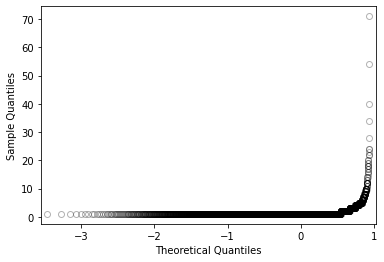

In [13]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code
# the graph look different than shown below.

# Random data points generated
# data_points = np.random.normal(0, 1, 100)

# sm.qqplot(nonna['CyclomaticComplexity'])
# pp = stats.probplot(new_data['CyclomaticComplexity'], dist="norm", plot=plt)
# pp = sm.ProbPlot(new_data['CyclomaticComplexity'], dist="norm", fit=True)
sm.qqplot(new_data['CyclomaticComplexity'], marker='o', markerfacecolor='none', markeredgecolor='k', alpha=0.3)
plt.show()

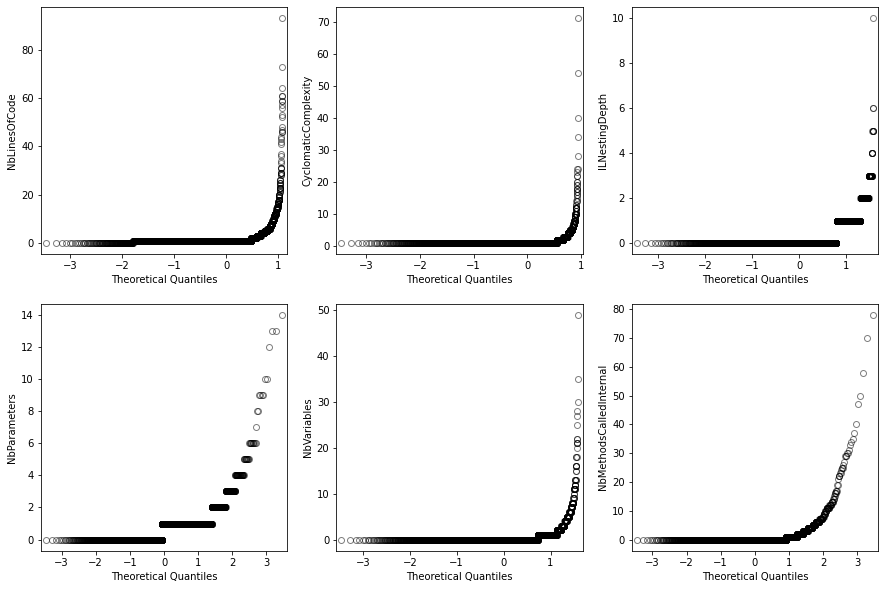

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax= axes.flatten()
for i in range(len(new_data.columns) -1):
    # ax = plt.subplot(10, 1, i+1)
    col = new_data.columns[i]
    sm.qqplot(new_data[col], marker='o', markerfacecolor='none', markeredgecolor='k', alpha=0.5,
              ax = ax[i])
    ax[i].set_ylabel(col)

# plt.tight_layout(pad=1.5)
# plt.show()

plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/qqplots.pdf')

In [44]:
x = change_data['Changes']
# x = x[~np.isnan(x)]
type(x[0])

numpy.int64

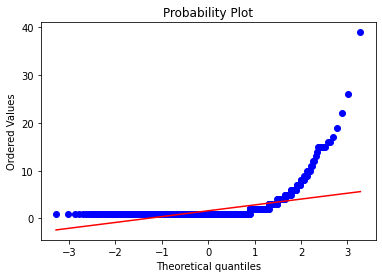

In [45]:
stats.probplot(change_data['Changes'], dist="norm", plot=plt)
plt.show()

In [ ]:
from sklearn import datasets
d = datasets.load_iris().data
d.size

In [ ]:

plt.hist(new_data['NbLinesOfCode'], bins=np.arange(new_data['NbLinesOfCode'].min(), new_data['NbLinesOfCode'].max()+1))
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot.pdf')

c:\users\aprodea\work\code-analyze\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\aprodea\work\code-analyze\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\aprodea\work\code-analyze\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

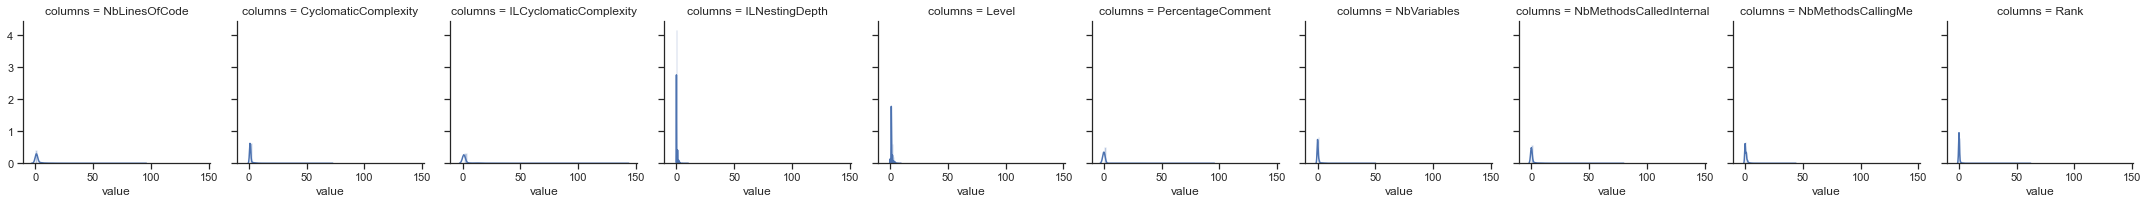

In [79]:
import seaborn as sns

dfm = new_data.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot3.pdf')

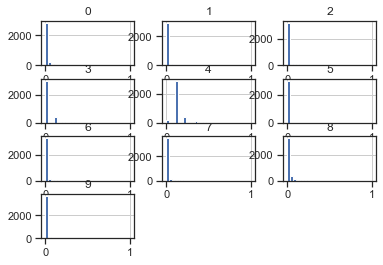

In [65]:
new_data = metrics_data[['NbLinesOfCode', 'CyclomaticComplexity', 'ILCyclomaticComplexity', 'ILNestingDepth', 'Level',
                         'PercentageComment', 'NbVariables', 'NbMethodsCalledInternal', 'NbMethodsCallingMe', 'Rank']]

x = new_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_data = pd.DataFrame(x_scaled)


new_data.hist(bins=30)
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot2.pdf')

In [23]:
el = new_data['NbLinesOfCode'][0]
type(el)

KeyError: 'NbLinesOfCode'

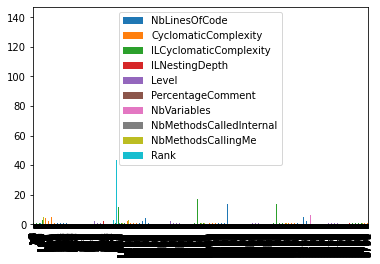

In [36]:
new_data.plot.bar()
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-bars.pdf')

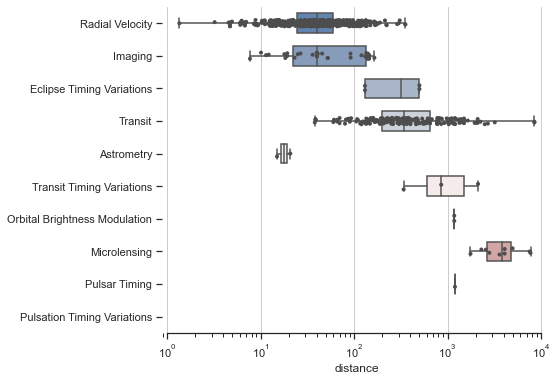

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="distance", y="method", data=planets,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="distance", y="method", data=planets,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [51]:
planets

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


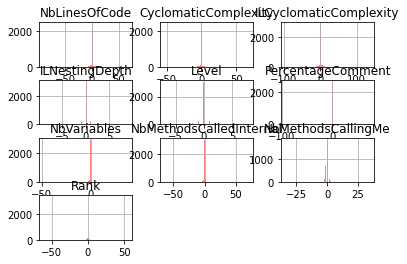

In [44]:
new_data.diff().hist(color='red', alpha=0.5, bins=100)
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-bins.pdf')

c:\users\aprodea\work\code-analyze\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


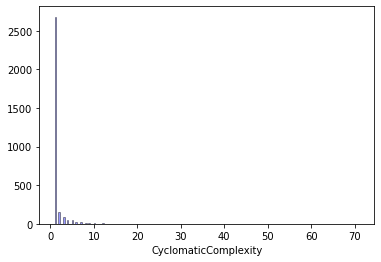

In [49]:
# matplotlib histogram
# plt.hist(new_data['CyclomaticComplexity'], color = 'blue', edgecolor = 'black',
#          bins = int(180))

# seaborn histogram
sns.distplot(new_data['CyclomaticComplexity'], hist=True, kde=False,
             bins=int(180), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-hist.pdf')

<ipython-input-62-f987f4f89e97>:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout(pad=1.5)


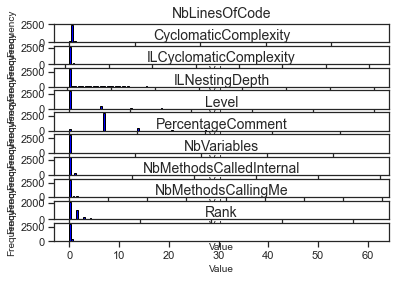

In [62]:
for i in range(len(new_data.columns)):
    ax = plt.subplot(10, 1, i+1)
    col = new_data.columns[i]
    ax.hist(new_data[col], bins=180, color = 'blue', edgecolor = 'black')
    ax.set_title(col, size = 14)
    ax.set_xlabel('Value', size = 10)
    ax.set_ylabel('Frequency', size= 10)
# plt.show()
plt.tight_layout(pad=1.5)
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-hist2.pdf')

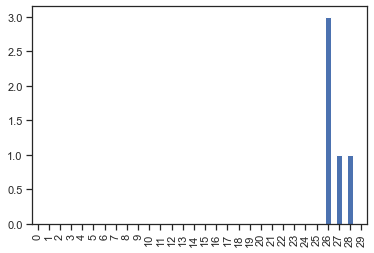

In [70]:
new_data['CyclomaticComplexity'][:30].plot.bar()
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-bars-col1a.pdf')

In [82]:
from collections import Counter

x = new_data['CyclomaticComplexity']
x = x[~np.isnan(x)]
print(Counter(x))

# plt.hist(x)

Counter({1.0: 2683, 2.0: 154, 3.0: 92, 4.0: 55, 5.0: 45, 6.0: 18, 7.0: 17, 8.0: 14, 10.0: 11, 12.0: 7, 9.0: 7, 18.0: 3, 14.0: 3, 16.0: 2, 19.0: 2, 17.0: 2, 11.0: 2, 22.0: 2, 13.0: 2, 20.0: 2, 24.0: 2, 15.0: 1, 23.0: 1, 28.0: 1, 71.0: 1, 40.0: 1, 34.0: 1, 54.0: 1})


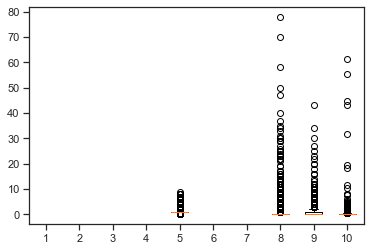

In [77]:
fig, ax = plt.subplots()
ax.boxplot(new_data)

plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-boxes.pdf')

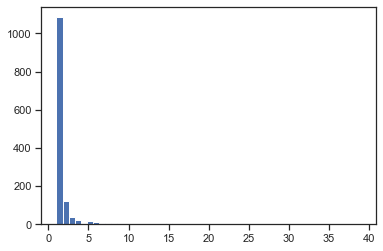

In [83]:
x = change_data['Changes']
plt.hist(x, bins=50)
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-changes.pdf')

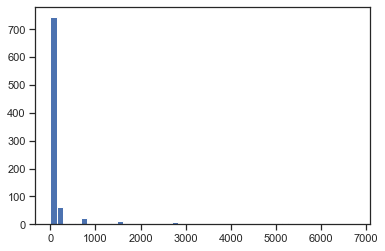

In [102]:
x = usage_data['Calls']
plt.hist(x, bins=50)
plt.locator_params(axis='x', nbins=10)
# plt.yticks(ticks=[0, 10, 20, 30, 50, 100, 500, 700])
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-calls.pdf')

In [94]:
usage_data['Calls'] = pd.to_numeric(usage_data['Calls'])
# print (metrics_data.dtypes)
# print (change_data.dtypes)
print (usage_data.dtypes)

Methods    object
Calls       int64
dtype: object


In [96]:
x = usage_data['Calls']
x = x[~np.isnan(x)]
print(Counter(x))

Counter({1: 392, 2: 82, 3: 37, 252: 30, 12: 23, 152: 21, 4: 17, 53: 17, 10: 16, 7: 14, 9: 13, 6: 11, 84: 10, 8: 10, 42: 9, 702: 9, 5: 7, 32: 7, 1583: 7, 701: 7, 33: 6, 48: 6, 44: 6, 705: 5, 1518: 5, 168: 4, 254: 4, 35: 4, 21: 4, 24: 4, 5237: 4, 85: 3, 43: 3, 20: 3, 2825: 3, 23: 3, 504: 2, 14: 2, 64: 2, 406: 2, 363: 2, 95: 2, 16: 2, 31: 2, 60: 2, 6755: 2, 26: 2, 71: 2, 17: 2, 495: 1, 192: 1, 2809: 1, 50: 1, 36: 1, 19: 1, 97: 1, 40: 1, 58: 1, 18: 1, 768: 1, 15: 1, 1026: 1, 86: 1, 215: 1, 135: 1, 25: 1, 704: 1, 2881: 1, 2828: 1, 2834: 1, 3531: 1, 2830: 1, 490: 1, 1409: 1, 1408: 1, 28: 1, 1403: 1, 2186: 1, 27: 1, 11: 1, 88: 1, 105: 1, 13: 1, 57: 1})


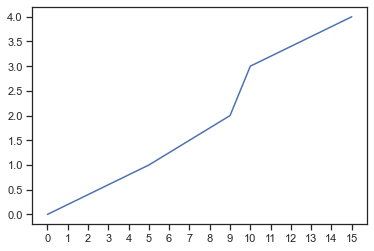

In [98]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

x = [0,5,9,10,15]
y = [0,1,2,3,4]

tick_spacing = 1

fig, ax = plt.subplots(1,1)
ax.plot(x,y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.show()

In [104]:
x = usage_data['Calls']
x = x[~np.isnan(x)]
print('Calls: ', Counter(x))

x = change_data['Changes']
x = x[~np.isnan(x)]
print('Changes: ', Counter(x))

for col in new_data.columns:
    x = new_data[col]
    x = x[~np.isnan(x)]
    print(col,': ', Counter(x))

Calls:  Counter({1: 392, 2: 82, 3: 37, 252: 30, 12: 23, 152: 21, 4: 17, 53: 17, 10: 16, 7: 14, 9: 13, 6: 11, 84: 10, 8: 10, 42: 9, 702: 9, 5: 7, 32: 7, 1583: 7, 701: 7, 33: 6, 48: 6, 44: 6, 705: 5, 1518: 5, 168: 4, 254: 4, 35: 4, 21: 4, 24: 4, 5237: 4, 85: 3, 43: 3, 20: 3, 2825: 3, 23: 3, 504: 2, 14: 2, 64: 2, 406: 2, 363: 2, 95: 2, 16: 2, 31: 2, 60: 2, 6755: 2, 26: 2, 71: 2, 17: 2, 495: 1, 192: 1, 2809: 1, 50: 1, 36: 1, 19: 1, 97: 1, 40: 1, 58: 1, 18: 1, 768: 1, 15: 1, 1026: 1, 86: 1, 215: 1, 135: 1, 25: 1, 704: 1, 2881: 1, 2828: 1, 2834: 1, 3531: 1, 2830: 1, 490: 1, 1409: 1, 1408: 1, 28: 1, 1403: 1, 2186: 1, 27: 1, 11: 1, 88: 1, 105: 1, 13: 1, 57: 1})
Changes:  Counter({1: 1085, 2: 120, 3: 37, 4: 25, 5: 16, 6: 12, 7: 7, 8: 5, 15: 5, 10: 4, 9: 4, 11: 2, 12: 2, 16: 2, 17: 1, 13: 1, 26: 1, 19: 1, 14: 1, 39: 1, 22: 1})
NbLinesOfCode :  Counter({1.0: 2463, 0.0: 138, 2.0: 134, 3.0: 97, 4.0: 88, 5.0: 62, 6.0: 51, 8.0: 28, 7.0: 24, 12.0: 22, 9.0: 19, 14.0: 16, 10.0: 14, 11.0: 12, 16.0: 9, 18

In [107]:
import holoviews as hv
from holoviews import opts

frequencies, edges = np.histogram(change_data['Changes'])
hv.Histogram((edges, frequencies))

:Histogram   [x]   (Frequency)

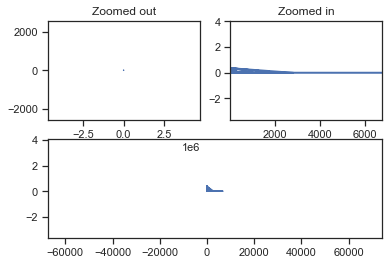

<Figure size 432x288 with 0 Axes>

In [108]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)
t1 = usage_data['Calls']

ax1 = plt.subplot(212)
ax1.margins(10)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1))

ax2 = plt.subplot(221)
ax2.margins(700, 7000)           # Values >0.0 zoom out
ax2.plot(t1, f(t1))
ax2.set_title('Zoomed out')

ax3 = plt.subplot(222)
ax3.margins(x=0, y=10)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1))
ax3.set_title('Zoomed in')

plt.show()


plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-calls-zoom.pdf')

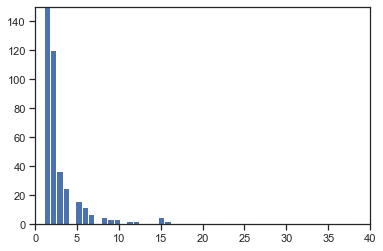

In [121]:
x = usage_data['Calls']
# x = x[~np.isnan(x)]
# def remove_one(val):
#     if val > 1:
#         return val

x = change_data['Changes']
plt.hist(x, bins=50)
# plt.yticks([0, 200])
plt.axis([0, 40, 0, 150])
plt.savefig('C:/Users/aprodea/work/metrics-tax-compare/plot-changesa.pdf')